## Web scraping of Falcon 9 Launches Records from Wikipedia


Web Scrapping data collected from wikipedia of `List of Falcon 9 and Falcon Heavy launches`

https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches


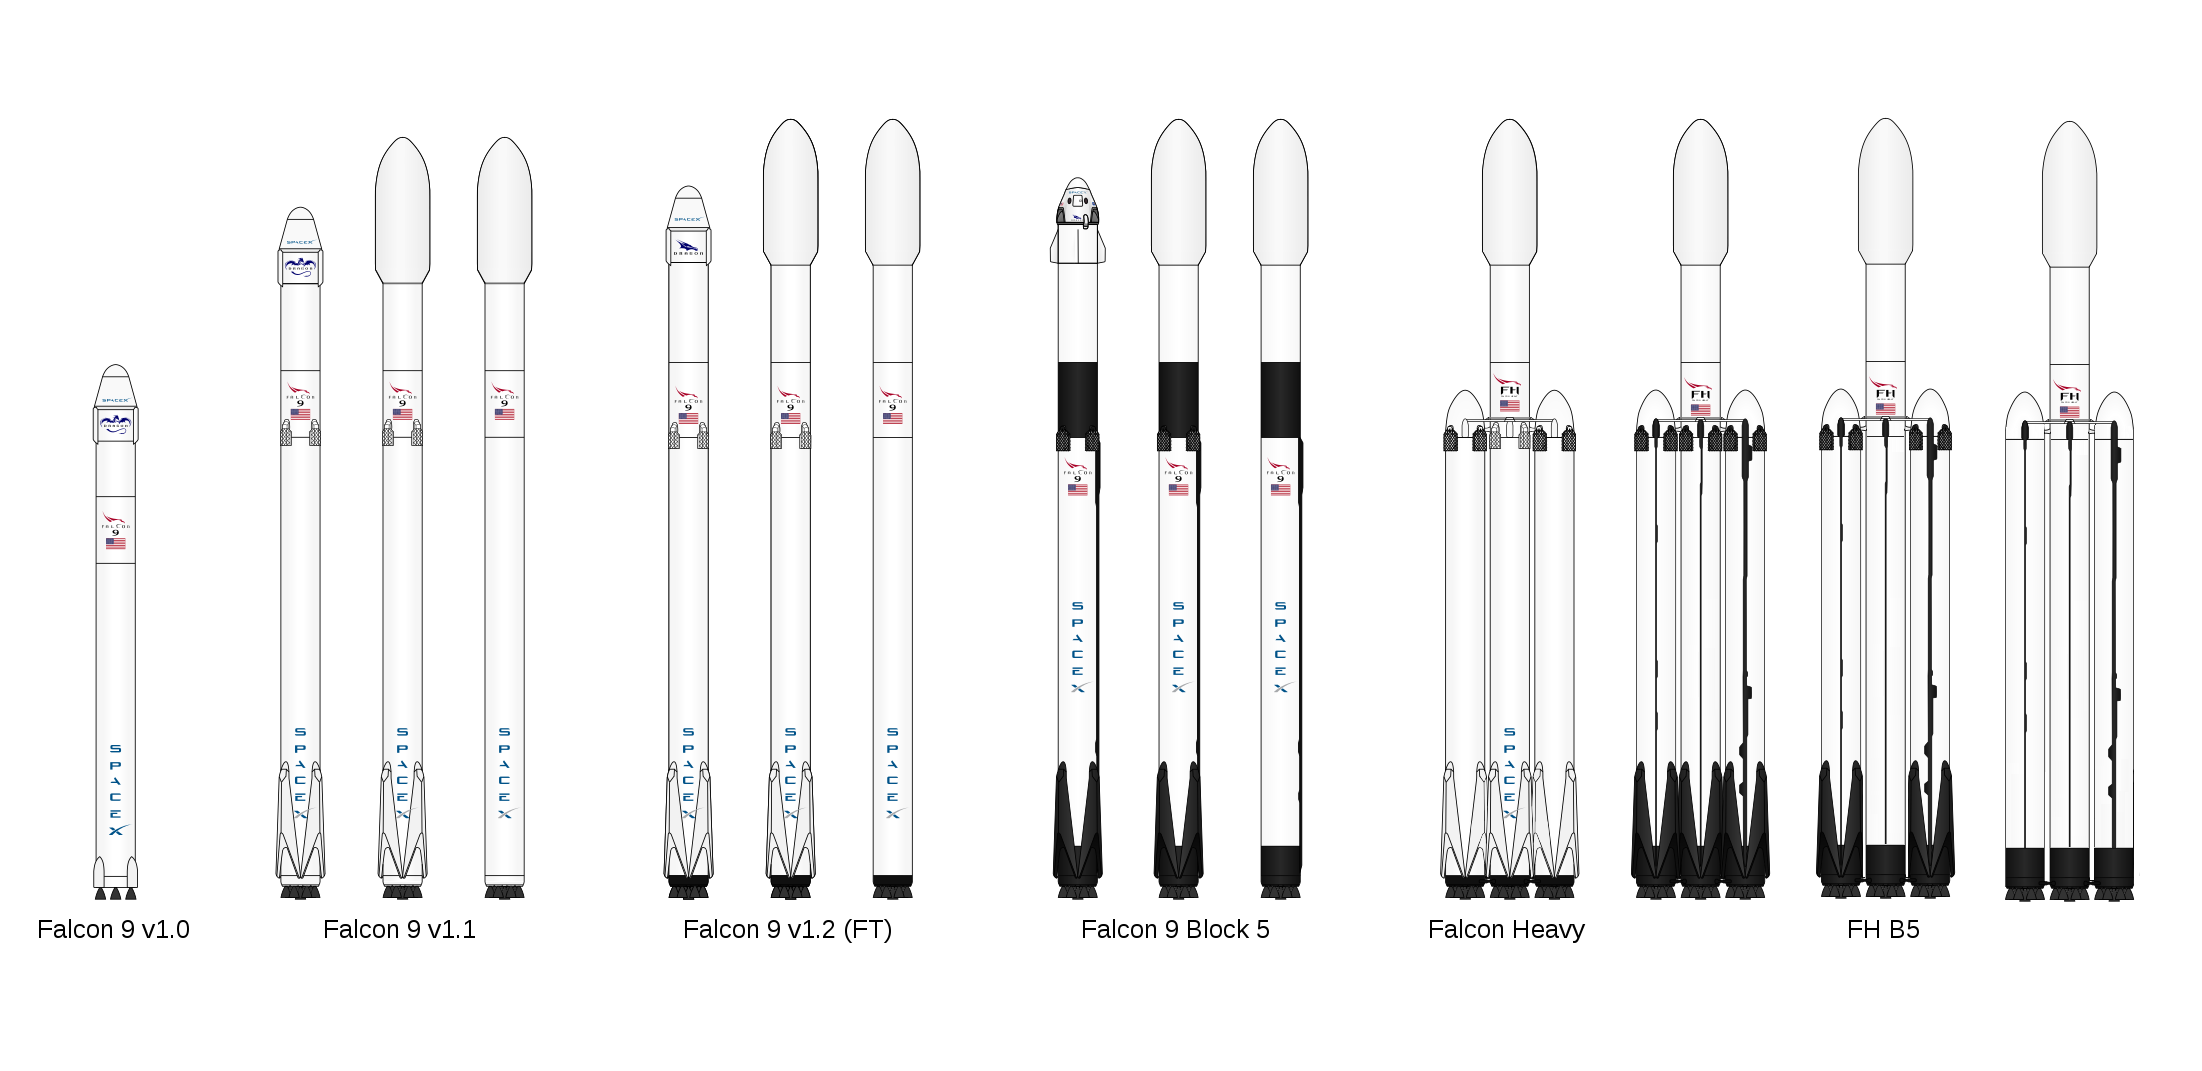

Falcon 9 first stage will land successfully


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


More specifically, the launch records are stored in a HTML table shown below:


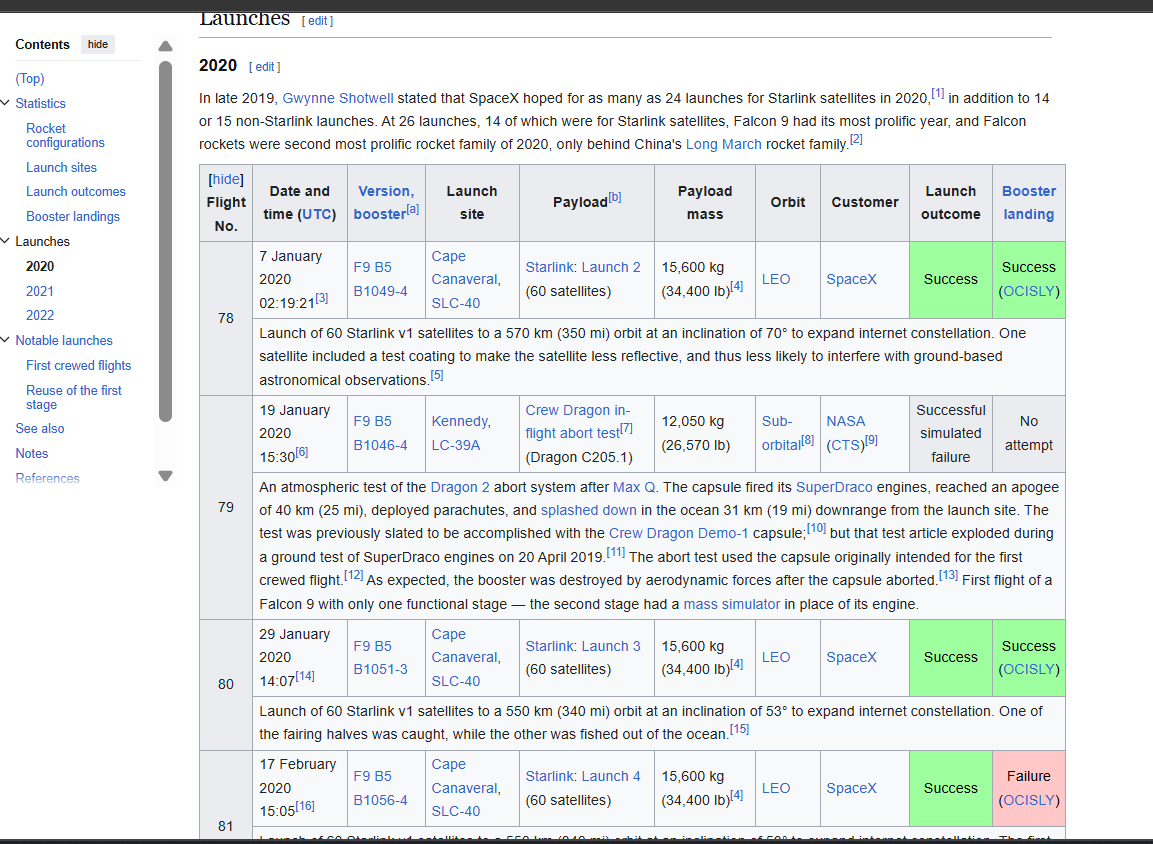


  ## Objectives
Web scrap Falcon 9 launch records with `BeautifulSoup`: 
- Extract a Falcon 9 launch records HTML table from Wikipedia
- Parse the table and convert it into a Pandas data frame


First let's import required packages for this lab


In [1]:
!pip3 install beautifulsoup4
!pip3 install requests


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import re
import unicodedata
import sys
import requests
from bs4 import BeautifulSoup


and we will provide some helper functions for you to process web scraped HTML table


In [3]:
    # This function returns the data and time from the HTML table cell
    # Input: the  element of a table data cell extracts extra row
def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]


    # This function returns the booster version from the HTML  table cell 
    # Input: the  element of a table data cell extracts extra row
def booster_version(table_cells):
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out


    # This function returns the landing status from the HTML table cell 
    # Input: the  element of a table data cell extracts extra row
def landing_status(table_cells):
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


    # This function returns the landing status from the HTML table cell 
    # Input: the  element of a table data cell extracts extra row
def extract_column_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty the names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the  `List of Falcon 9 and Falcon Heavy launches` Wikipage updated on
`9th June 2021`


In [4]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

Next, request the HTML page from the above URL and get a `response` object


### Request the Falcon9 Launch Wiki page from its URL


First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.


In [5]:
# use requests.get() method with the provided static_url
# assign the response to a object

html_data = requests.get(static_url)
html_data.status_code

403

Create a `BeautifulSoup` object from the HTML `response`


In [6]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content

soup = BeautifulSoup(html_data.text)

Print the page title to verify if the `BeautifulSoup` object was created properly 


In [7]:
# Use soup.title attribute

soup.title

### Extract all column/variable names from the HTML table header


Next, we want to collect all relevant column names from the HTML table header


Let's try to find all tables on the wiki page first. If you need to refresh your memory about `BeautifulSoup`, please check the external reference link towards the end of this lab


In [8]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`

html_tables = soup.find_all('table')

Starting from the third table is our target table contains the actual launch records.


In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# ---- Fetch content ----
API_URL = ("https://en.wikipedia.org/api/rest_v1/page/html/"
           "List_of_Falcon_9_and_Falcon_Heavy_launches")
headers = {
    "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
                   " AppleWebKit/537.36 (KHTML, like Gecko)"
                   " Chrome/115.0 Safari/537.36")
}

r = requests.get(API_URL, headers=headers)
r.raise_for_status()

soup = BeautifulSoup(r.content, "html.parser")
html_tables = soup.find_all("table")

# ---- Helper to pick the right table ----
def extract_column_from_header(row):
    for tag in ('br', 'a', 'sup'):
        for elem in row.find_all(tag):
            elem.extract()
    text = row.get_text(" ", strip=True)
    return None if text.isdigit() else text

def get_launch_table(tables):
    for t in tables:
        headers = [extract_column_from_header(th) for th in t.find_all("th")]
        headers = [h for h in headers if h]
        if any("date" in h.lower() for h in headers):
            return t, headers
    return None, None

table, column_names = get_launch_table(html_tables)
if table is None:
    raise RuntimeError("Launch table not found—even after using REST API.")

print("Detected columns:", column_names)

# ---- Extract rows into DataFrame ----
rows = []
for row in table.find_all("tr")[1:]:  # skip header
    cells = row.find_all("td")
    row_data = [cell.get_text(" ", strip=True) for cell in cells]
    if len(row_data) == len(column_names):
        rows.append(row_data)
    else:
        # Optionally handle mismatched row lengths...
        rows.append(row_data + [""] * (len(column_names) - len(row_data)))

df = pd.DataFrame(rows, columns=column_names)
print(df.head())


Detected columns: ['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome', 'FH 10', 'FH 11']
                                          Flight No. Date and time ( )  \
0                       January 3, 2024 03:44 [ 24 ]   F9 B5 B1082 ‑ 1   
1  Launch of 22 Starlink v2 mini satellites, incl...                     
2                       January 3, 2024 23:04 [ 25 ]  F9 B5 B1076 ‑ 10   
3  Broadband internet provider satellite. [ 26 ] ...                     
4                       January 7, 2024 22:35 [ 29 ]  F9 B5 B1067 ‑ 16   

                 Launch site                                Payload  \
0      Vandenberg , SLC ‑ 4E   Starlink : Group 7-9 (22 satellites)   
1                                                                     
2  Cape Canaveral , SLC ‑ 40                                Ovzon-3   
3                                                                     
4  Cape Canaveral , SLC ‑ 40  Starlink : Group 

You should able to see the columns names embedded in the table header elements `<th>` as follows:


```
<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
```


Iterating through the `<th>` elements and applying the provided `extract_column_from_header()` to extract column names one by one


In [10]:


# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names

# Function to extract the launch table dynamically
def get_launch_table(tables):
    for table in tables:
        headers = [th.get_text(strip=True) for th in table.find_all("th")]
        if any("Date" in h or "Launch" in h for h in headers):
            return table
    return None

# Get the correct launch table
first_launch_table = get_launch_table(html_tables)

if first_launch_table is None:
    raise ValueError("Launch table not found. Check Wikipedia page structure.")

# Extract column names safely
column_names = []
for element in first_launch_table.find_all('th'):
    name = extract_column_from_header(element)
    if name is not None and len(name) > 0:
        column_names.append(name)

print(column_names)




['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome', 'FH 10', 'FH 11']


Check the extracted column names


In [11]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome', 'FH 10', 'FH 11']


## Create a data frame by parsing the launch HTML tables


We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe


In [12]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the `launch_dict` with launch records extracted from table rows.


Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links `B0004.1[8]`, missing values `N/A [e]`, inconsistent formatting, etc.


To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the `launch_dict`. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:


In [13]:
extracted_row = 0

# Iterate over each collapsible SpaceX launch table
for idx, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    for tr in table.find_all("tr"):
        
        # Check if the row starts with a valid launch number
        if tr.th and tr.th.string:
            flight_no = tr.th.string.strip()
            valid_row = flight_no.isdigit()
        else:
            valid_row = False

        cells = tr.find_all("td")

        if valid_row:
            extracted_row += 1
            
            # Flight Number
            launch_dict['Flight No.'].append(flight_no)

            # Date & Time info
            date_info, time_info = date_time(cells[0])
            launch_dict['Date'].append(date_info.strip(','))
            launch_dict['Time'].append(time_info)

            # Booster information
            booster = booster_version(cells[1])
            if not booster and cells[1].a:
                booster = cells[1].a.string
            launch_dict['Version Booster'].append(booster)

            # Launch Location
            launch_dict['Launch site'].append(cells[2].a.string)

            # Payload Name
            launch_dict['Payload'].append(cells[3].a.string)

            # Payload Mass (if available)
            payload_mass = get_mass(cells[4])
            launch_dict['Payload mass'].append(payload_mass)

            # Orbit Type
            launch_dict['Orbit'].append(cells[5].a.string)

            # Customer(s)
            try:
                client = cells[6].a.string
            except:
                client = 'Various'
            launch_dict['Customer'].append(client)

            # Mission Result
            outcome = list(cells[7].strings)[0]
            launch_dict['Launch outcome'].append(outcome)

            # Booster Recovery
            recovery_status = landing_status(cells[8])
            launch_dict['Booster landing'].append(recovery_status)


After the filling is done in the parsed launch record values into `launch_dict`, the dataframe can be created from it.

In [14]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })

This can now be exported to a <b>CSV</b> for the next section, but to make the answers consistent and in case you have difficulties finishing this lab. 



In [15]:
df.to_csv('spacex_web_scraped.csv', index=False)
